In [39]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
import tensorflow as tf  
import tensorflow_federated as tff
from PIL import Image
import nest_asyncio
from tensorflow_privacy import DPGradientDescentGaussianOptimizer
nest_asyncio.apply()
tf.config.run_functions_eagerly(True)

In [40]:
# Define the path to the dataset
dataset_path = 'UTKFace' 

# Initialize lists to hold images and labels
images = []
ages = []
genders = []
races = []

# Load images and extract labels from filenames
for img_name in os.listdir(dataset_path):
    if img_name.endswith('.jpg'):
        parts = img_name.split('_')
        if len(parts) >= 4:
            try:
                age, gender, race = parts[:3]
                ages.append(int(age))
                genders.append(int(gender))
                races.append(int(race))

                img_path = os.path.join(dataset_path, img_name)
                img = Image.open(img_path).resize((32, 32))
                img = np.array(img)
                images.append(img)
            except ValueError as e:
                print(f"Skipping file {img_name}: {e}")
        else:
            print(f"Skipping file {img_name}: not enough values to unpack (expected 4, got {len(parts)})")

# Convert lists to numpy arrays
images = np.array(images)
ages = np.array(ages)
genders = np.array(genders)
races = np.array(races)

# Encode race labels
label_encoder = LabelEncoder()
y_data_race_encoded = label_encoder.fit_transform(races)

# Normalize the images
images = images.astype(np.float32) / 255.0

Skipping file 39_1_20170116174525125.jpg.chip.jpg: not enough values to unpack (expected 4, got 3)
Skipping file 61_1_20170109142408075.jpg.chip.jpg: not enough values to unpack (expected 4, got 3)
Skipping file 61_1_20170109150557335.jpg.chip.jpg: not enough values to unpack (expected 4, got 3)


In [41]:
# Create a DataFrame to facilitate balancing
data = {
    'image': list(images),
    'age': ages,
    'gender': genders,
    'race': y_data_race_encoded
}
df = pd.DataFrame(data)

# Balance the dataset by oversampling the minority classes
df_majority = df[df.race == df.race.mode()[0]]
df_minority = df[df.race != df.race.mode()[0]]

# Oversample the minority classes
df_minority_oversampled = resample(df_minority,
                                   replace=True,  # Sample with replacement
                                   n_samples=len(df_majority),  # Match number of majority class
                                   random_state=42)  # Reproducible results

# Combine majority class with oversampled minority classes
data_balanced = pd.concat([df_majority, df_minority_oversampled])

# Shuffle the dataset
data_balanced = data_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Extract balanced images and labels
images_balanced = np.array(list(data_balanced['image']))
ages_balanced = np.array(data_balanced['age'])
genders_balanced = np.array(data_balanced['gender'])
races_balanced = np.array(data_balanced['race'])

In [42]:
# Split balanced data into train, validation, and test sets
x_temp, x_test, y_temp, y_test = train_test_split(images_balanced.astype(np.float32), races_balanced, test_size=0.2, stratify=races_balanced, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_temp.astype(np.float32), y_temp, test_size=0.25, stratify=y_temp, random_state=42)  # 0.25 x 0.8 = 0.2

In [44]:
# Define the Keras model architecture
def create_keras_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(32, 32, 3)),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')  # Adjust number of classes as needed
    ])
    return model

# Create the Keras model
model = create_keras_model()

# Define the DP optimizer
dp_optimizer = DPGradientDescentGaussianOptimizer(
    l2_norm_clip=1.0,
    noise_multiplier=1.1,
    num_microbatches=1,
    learning_rate=0.02
)

# Compile the model with the DP optimizer
model.compile(optimizer=dp_optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=10, batch_size=32, validation_data=(x_test, y_test))

# Evaluate the model
test_loss, test_accuracy = model.evaluate(x_test, y_test)
print(f'Test accuracy: {test_accuracy}')

# Generate predictions on the test data
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

# Perform bias analysis
# Visualize the distribution of images across different races
race_counts = pd.Series(races).value_counts()
sns.barplot(x=race_counts.index, y=race_counts.values)
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Distribution of Images Across Different Races')
plt.show()

NotImplementedError: numpy() is only available when eager execution is enabled.

In [19]:
def evaluate_performance(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, precision, recall, f1

for race in np.unique(y_test):
    indices = [i for i, r in enumerate(y_test) if r == race]
    y_true_race = [y_test[i] for i in indices]
    y_pred_race = [y_pred[i] for i in indices]
    
    accuracy, precision, recall, f1 = evaluate_performance(y_true_race, y_pred_race)
    print(f'Race: {race}')
    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}\n')

# Analyze misclassifications
misclassified_indices = [i for i, (true, pred) in enumerate(zip(y_test, y_pred)) if true != pred]

for idx in misclassified_indices:
    img = x_test[idx]
    true_label = y_test[idx]
    predicted_label = y_pred[idx]
    
    plt.imshow(img)
    plt.title(f'True: {true_label}, Predicted: {predicted_label}')
    plt.show()

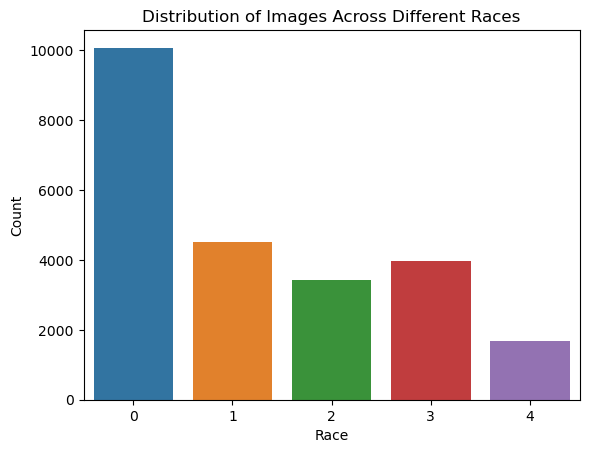

In [7]:

# Visualize the distribution of images across different races
import matplotlib.pyplot as plt
import seaborn as sns

race_counts = pd.Series(races).value_counts()
sns.barplot(x=race_counts.index, y=race_counts.values)
plt.xlabel('Race')
plt.ylabel('Count')
plt.title('Distribution of Images Across Different Races')
plt.show()


In [20]:

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

def evaluate_performance(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    return accuracy, precision, recall, f1

# Evaluate metrics for each race
for race in np.unique(y_test):
    indices = [i for i, r in enumerate(y_test) if r == race]
    y_true_race = y_test[indices]
    y_pred_race = y_pred[indices]
    
    accuracy, precision, recall, f1 = evaluate_performance(y_true_race, y_pred_race)
    print(f'Race: {race}')
    print(f'Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1 Score: {f1:.4f}\n')

Race: 0
Accuracy: 0.8264, Precision: 0.2500, Recall: 0.2066, F1 Score: 0.2262

Race: 1
Accuracy: 0.8156, Precision: 0.2500, Recall: 0.2039, F1 Score: 0.2246

Race: 2
Accuracy: 0.5352, Precision: 0.2500, Recall: 0.1338, F1 Score: 0.1743

Race: 3
Accuracy: 0.6129, Precision: 0.2500, Recall: 0.1532, F1 Score: 0.1900

Race: 4
Accuracy: 0.0000, Precision: 0.0000, Recall: 0.0000, F1 Score: 0.0000



c:\Users\anoop\anaconda3\envs\tff_env\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\anoop\anaconda3\envs\tff_env\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\anoop\anaconda3\envs\tff_env\lib\site-packages\sklearn\metrics\_classification.py:1248: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\anoop\anaconda3\envs\tff_env\lib\site-packages\sklearn\metrics\_classi